In [3]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

In [4]:
# Loading Mat file
mat=loadmat('ex5data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y
Xtest
ytest
Xval
yval


In [5]:
# Loading training data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
data['X']=mat['X'].reshape(-1)
data['y']=mat['y'].reshape(-1)

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data

TRAINING DATASET SHAPE : 12 X 2


,X,y
0,-15.936758,2.134311
1,-29.152979,1.173257
2,36.189549,34.359109
3,37.492187,36.837955
4,-48.058829,2.808965
5,-8.941458,2.121072
6,15.307793,14.710268
7,-34.706266,2.614184
8,1.389154,3.740172
9,-44.383760,3.731691


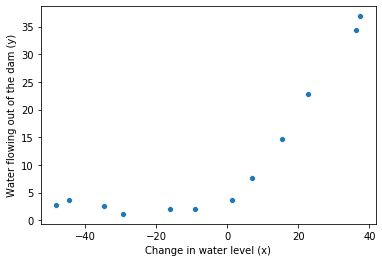

In [6]:

ax=sns.scatterplot(data['X'],data['y']);
ax.set(xlabel='Change in water level (x)',ylabel='Water flowing out of the dam (y)');

In [7]:

def predict(X,theta):
    '''Predicts using the Linear Model'''
    h=np.dot(X,theta.T)
    return h

In [8]:

def computeCost(X,y,theta,lmbda):
    '''Computes and returns the cost and gradient'''
    m=y.shape[0]
    h=predict(X,theta)
    J=(1/(2*m))*(np.power(h-y,2).sum()+lmbda*np.power(theta[:,1:],2).sum())
    grad=(1/m)*(np.dot((h-y).T,X)+lmbda*np.column_stack((np.zeros(shape=(1,1)),theta[:,1:])))
    return (J,grad)

In [9]:
X=data['X']
# Adding intercept column
X=np.column_stack((np.ones((m,1)),X))
y=data['y'].values.reshape((-1,1))
theta=np.ones((1,2))
lmbda=1

J,grad=computeCost(X,y,theta,lmbda)
print(f'REGULARIZED COST FUNCTION : {J:.3f}')
print(f'GRADIENT : {grad[0]}')

REGULARIZED COST FUNCTION : 303.993
GRADIENT : [-15.30301567 598.25074417]


In [10]:
def train(X,y,alpha,lmbda,iterations):
    '''Trains the linear regression model using gradient descent optimization algorithm'''
    theta=np.zeros((1,X.shape[1]))
    jHistory=[]
    for i in range(iterations):
        J,grad=computeCost(X,y,theta,lmbda)
        theta=theta-alpha*grad
        jHistory.append(J)
    return jHistory,theta

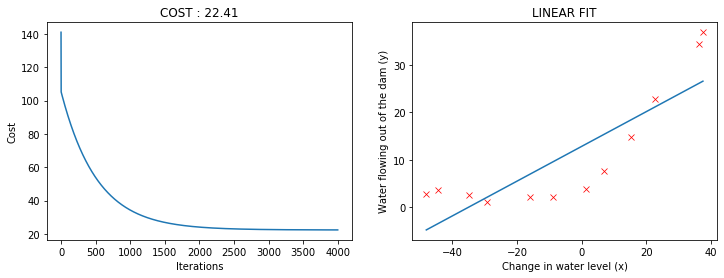

In [11]:

alpha=0.001
lmbda=0
iterations=4000

# Training
jHistory,theta=train(X,y,alpha,lmbda,iterations)

# Plotting cost curve
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
ch1=sns.lineplot(range(iterations),jHistory,ax=ax[0])
ch1.set(xlabel='Iterations',yLabel='Cost')
ax[0].set_title(f'COST : {jHistory[iterations-1]:.2f}')

# Plotting model and data
sns.scatterplot(data['X'],data['y'],color='red',marker='x',ax=ax[1])
ch2=sns.lineplot(data['X'],predict(X,theta).reshape(-1),ax=ax[1])
ch2.set(xlabel='Change in water level (x)',ylabel='Water flowing out of the dam (y)')
ax[1].set_title('LINEAR FIT');

In [12]:
def learningCurve(X,y,Xval,yval,alpha,lmbda,iterations):
    '''Generates the train and cross validation set errors needed to plot a learning curve'''
    m=X.shape[0]
    errorTrain,errorVal=[],[]
    # Training model with different training set size
    for i in range(1,m+1):
        theta=train(X[:i,:],y[:i],alpha,lmbda,iterations)[1]
        # Computing training error using learned parameters
        errorTrain.append(computeCost(X[:i,:],y[:i],theta,lmbda)[0])
        # Computing cross validation error for the entire validation set
        errorVal.append(computeCost(Xval,yval,theta,lmbda)[0])
    return (errorTrain,errorVal)

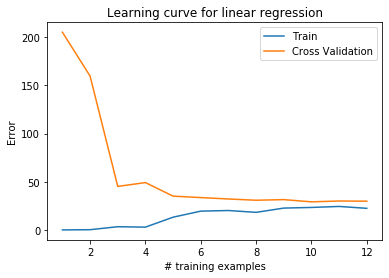

In [13]:

Xval=mat['Xval']
Xval=np.column_stack((np.ones((Xval.shape[0],1)),Xval))
yval=mat['yval'].reshape((-1,1))

errorTrain,errorVal=learningCurve(X,y,Xval,yval,alpha,lmbda,iterations)
sns.lineplot(range(1,m+1),errorTrain,label='Train')
ch=sns.lineplot(range(1,m+1),errorVal,label='Cross Validation')
ch.set(xlabel='# training examples',ylabel='Error',title='Learning curve for linear regression');

In [14]:

def polyFeatures(X,p):
    '''Maps each example into its p polynomial features'''
    xPoly=np.zeros(shape=(X.shape[0],p))
    for i in range(1,p+1):
        xPoly[:,i-1]=np.power(X,i)
    return xPoly

In [15]:

def featureNormalize(X,mean=None,std=None):
    '''Normalizes the Design Matrix'''
    if type(mean)== type(None) and type(std)==type(None):
        mean=X.mean(axis=0)
        std=X.std(axis=0)
    xNorm=(X-mean)/std
    return (xNorm,mean,std)

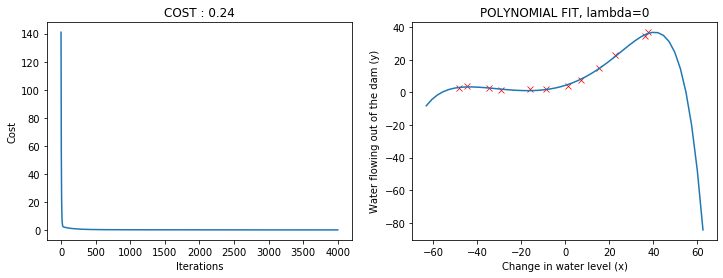

In [16]:
alpha=0.1
lmbda=0
iterations=4000
p=8

# Mapping X onto polynomial features
xPoly=polyFeatures(data['X'],p)
# Normalize features
xPoly,mean,std=featureNormalize(xPoly)
# Adding intercept column
xPoly=np.column_stack((np.ones((m,1)),xPoly))

# Training
jHistory,theta=train(xPoly,y,alpha,lmbda,iterations)

# Plotting cost curve
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
ch1=sns.lineplot(range(iterations),jHistory,ax=ax[0])
ch1.set(xlabel='Iterations',yLabel='Cost')
ax[0].set_title(f'COST : {jHistory[iterations-1]:.2f}')

# Plotting data 
sns.scatterplot(data['X'],data['y'],color='red',marker='x',ax=ax[1])
# Plotting model with extremes
x=np.linspace(data['X'].min()-15,data['X'].max()+25)
xTemp=polyFeatures(x,p)
# Normalizing with training set mean and std
xTemp=featureNormalize(xTemp,mean,std)[0]
xTemp=np.column_stack((np.ones((xTemp.shape[0],1)),xTemp))
ch2=sns.lineplot(x,predict(xTemp,theta).reshape(-1),ax=ax[1])
ch2.set(xlabel='Change in water level (x)',ylabel='Water flowing out of the dam (y)')
ax[1].set_title(f'POLYNOMIAL FIT, lambda={lmbda}');

In [17]:
xValPoly=polyFeatures(mat['Xval'].reshape(-1),p)
# Normalize features
xValPoly=featureNormalize(xValPoly,mean,std)[0]
# Adding intercept column
xValPoly=np.column_stack((np.ones((xValPoly.shape[0],1)),xValPoly))

errorTrain,errorVal=learningCurve(xPoly,y,xValPoly,yval,alpha,lmbda,iterations)

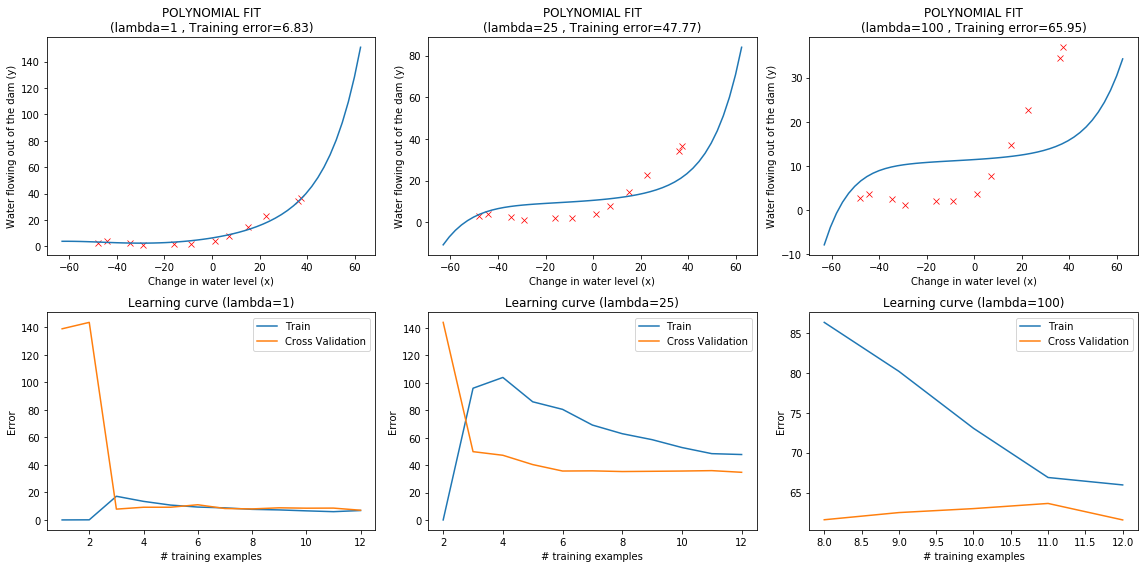

In [18]:

lmbdas=[1,25,100]

nrows,ncols=2,len(lmbdas)
fig,ax=plt.subplots(nrows,ncols,figsize=(16,8))

for i in range(ncols):
    # Training
    jHistory,theta=train(xPoly,y,alpha,lmbdas[i],iterations)
    # Plotting data 
    sns.scatterplot(data['X'],data['y'],color='red',marker='x',ax=ax[0][i])
    # Plotting model with extremes
    x=np.linspace(data['X'].min()-15,data['X'].max()+25)
    xTemp=polyFeatures(x,p)
    # Normalizing with training set mean and std
    xTemp=featureNormalize(xTemp,mean,std)[0]
    xTemp=np.column_stack((np.ones((xTemp.shape[0],1)),xTemp))
    ch2=sns.lineplot(x,predict(xTemp,theta).reshape(-1),ax=ax[0][i])
    ch2.set(xlabel='Change in water level (x)',ylabel='Water flowing out of the dam (y)')
    ax[0][i].set_title(f'POLYNOMIAL FIT\n(lambda={lmbdas[i]} , Training error={jHistory[iterations-1]:.2f})');
    errorTrain,errorVal=learningCurve(xPoly,y,xValPoly,yval,alpha,lmbdas[i],iterations)
    sns.lineplot(range(1,m+1),errorTrain,label='Train',ax=ax[1][i])
    ch=sns.lineplot(range(1,m+1),errorVal,label='Cross Validation',ax=ax[1][i])
    ch.set(xlabel='# training examples',ylabel='Error',title=f'Learning curve (lambda={lmbdas[i]})');
fig.tight_layout()

In [19]:
def validationCurve(X,y,Xval,yval,lmbdas):
    m=X.shape[0]
    errorTrain,errorVal=[],[]
    # Training model with different lambda values
    for lmbda in lmbdas:
        theta=train(X,y,alpha,lmbda,iterations)[1]
        # Computing training error using learned parameters
        errorTrain.append(computeCost(X,y,theta,lmbda)[0])
        # Computing cross validation error for the entire validation set
        errorVal.append(computeCost(Xval,yval,theta,lmbda)[0])        
    return (errorTrain,errorVal)

For lambda = 0.000	CV Error = 17.237
For lambda = 0.001	CV Error = 17.039
For lambda = 0.003	CV Error = 16.656
For lambda = 0.010	CV Error = 15.443
For lambda = 0.030	CV Error = 12.812
For lambda = 0.100	CV Error = 8.436
For lambda = 0.300	CV Error = 5.932
For lambda = 1.000	CV Error = 7.047
For lambda = 3.000	CV Error = 9.782
For lambda = 10.000	CV Error = 18.634

BEST LAMBDA VALUE : 0.3


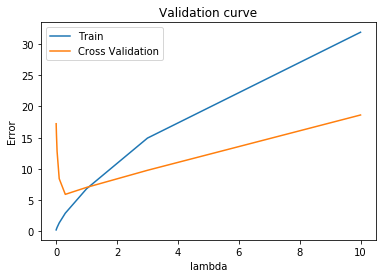

In [20]:
lmbdas=[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

errorTrain,errorVal=validationCurve(xPoly,y,xValPoly,yval,lmbdas)
# Plotting Validation curve
sns.lineplot(lmbdas,errorTrain,label='Train')
ch=sns.lineplot(lmbdas,errorVal,label='Cross Validation')
ch.set(xlabel='lambda',ylabel='Error',title='Validation curve');

for i in range(len(lmbdas)):
    print(f'For lambda = {lmbdas[i]:.3f}\tCV Error = {errorVal[i]:.3f}')

# Finding the right lambda value by choosing the model with lowest cross validation error
lmbda=lmbdas[np.argmin(np.array(errorVal))]
print(f'\nBEST LAMBDA VALUE : {lmbda}')

In [21]:
# Mapping X onto polynomial features
xTestPoly=polyFeatures(mat['Xtest'].reshape(-1),p)
# Normalize features
xTestPoly=featureNormalize(xTestPoly,mean,std)[0]
# Adding intercept column
xTestPoly=np.column_stack((np.ones((xTestPoly.shape[0],1)),xTestPoly))
yTest=mat['ytest']

# Training
jHistory,theta=train(xPoly,y,alpha,lmbda,iterations)

# Computing cost for test set
J=computeCost(xTestPoly,yTest,theta,lmbda)[0]
print(f'TEST Error : {J:.2f}')

TEST Error : 6.49
